In [1]:
!pip install -q ultralytics albumentations --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:0000:0100:01


# **Copy dataset to working directory**

In [2]:
!cp -r "/kaggle/input/waste-detection/waste detection data/" "/kaggle/working/dataset"

# Generating yaml config file 

In [3]:
from ruamel.yaml import YAML
import os

ROOT_TRAINING_FOLDER = "/kaggle/working/dataset"
# Correct the paths in the data dictionary
data = {
    'train': os.path.join(ROOT_TRAINING_FOLDER, 'train', 'images'),
    'val': os.path.join(ROOT_TRAINING_FOLDER, 'valid', 'images'),
    'nc': 7,
    'names': ['Aluminium', 'Glass', 'Tag', 'cardboard', 'rigid_plastic', 'soft_plastic', 'wood']
}

yaml = YAML()
with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

# Load dataset and create yaml

In [5]:
%%writefile /kaggle/working/data.yaml
# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/dataset/train
val: /kaggle/working/dataset/valid
test: /kaggle/working/dataset/test

# Number of classes
nc: 7

# Class names
names: ['Aluminium','Glass','Tag','cardboard ', ' rigid_plastic','soft_plastic','wood']

Overwriting /kaggle/working/data.yaml


# Check and verify dataset

In [6]:
from ultralytics.data.utils import check_det_dataset

check_det_dataset('/kaggle/working/data.yaml')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


{'train': '/kaggle/working/dataset/train',
 'val': '/kaggle/working/dataset/valid',
 'test': '/kaggle/working/dataset/test',
 'nc': 7,
 'names': {0: 'Aluminium',
  1: 'Glass',
  2: 'Tag',
  3: 'cardboard ',
  4: ' rigid_plastic',
  5: 'soft_plastic',
  6: 'wood'},
 'yaml_file': '/kaggle/working/data.yaml',
 'channels': 3,
 'path': PosixPath('/kaggle/working')}

In [7]:
from ultralytics import YOLO
import os, glob, random, shutil, cv2
import numpy as np
import torch
import albumentations as A
from tqdm import tqdm

# Segmentation Visualization

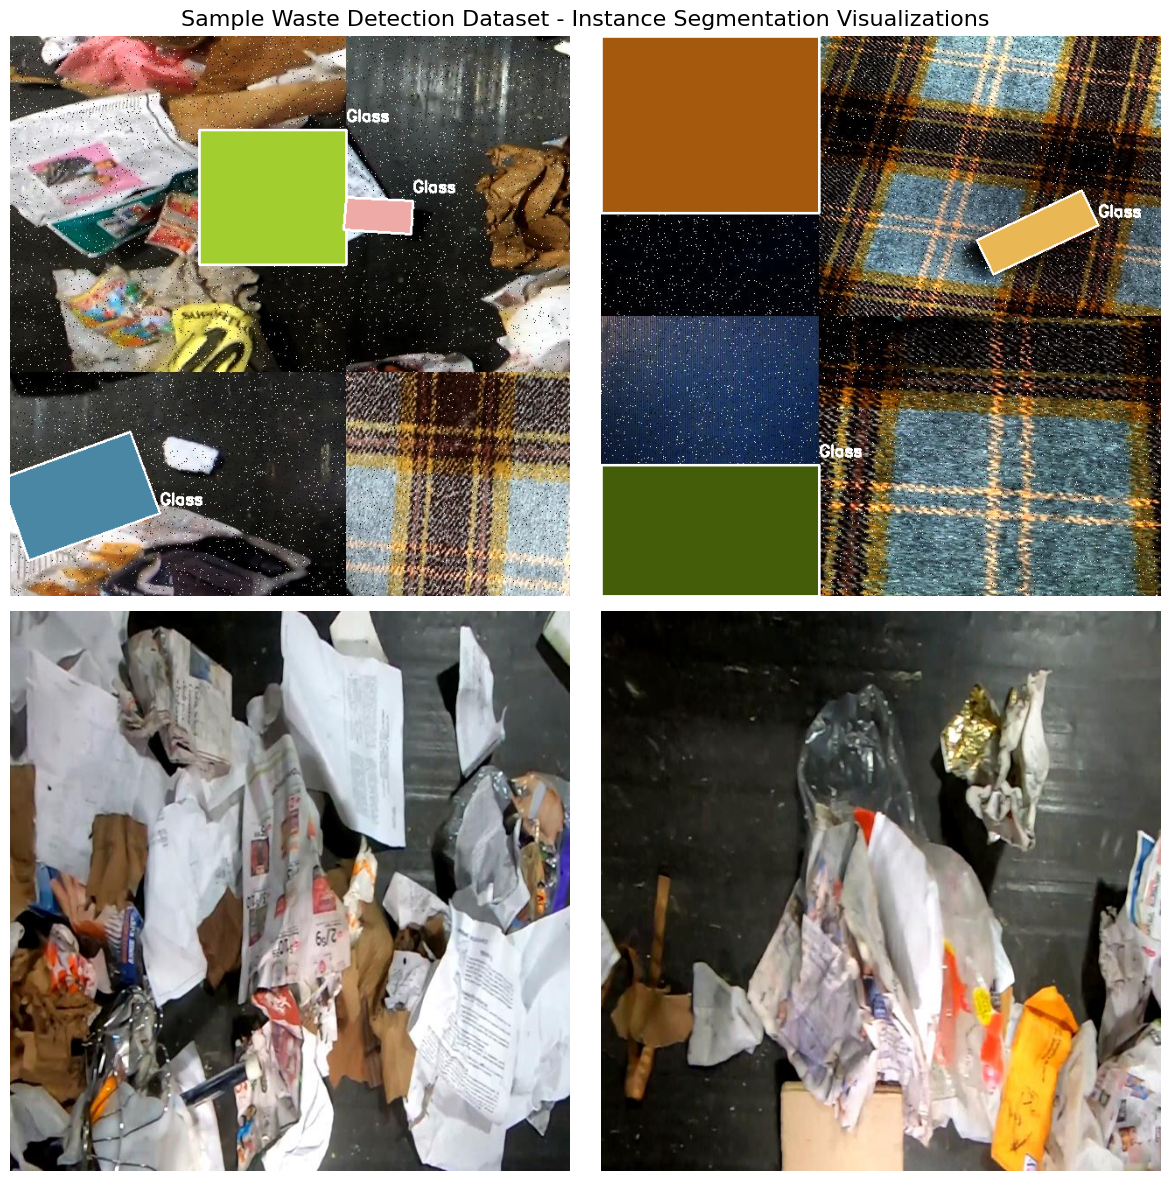

In [8]:
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# YOLOv12 Instance Segmentation Visualization (2x2 Grid)
# ============================================================

# Paths
image_dir = "/kaggle/working/dataset/train/images"
label_dir = "//kaggle/working/dataset/train/labels"

# Get random sample of 4 images
image_files = random.sample(os.listdir(image_dir), 4)

def visualize_image(img_path, label_path, class_name="Glass"):
    """Visualize one image with segmentation masks or bboxes."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((100, 100, 3), dtype=np.uint8)

    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            cls_id = int(values[0])
            coords = values[1:]

            # Polygon segmentation
            if len(coords) > 4:
                pts = np.array(coords).reshape(-1, 2)
                pts[:, 0] *= w
                pts[:, 1] *= h
                pts = pts.astype(np.int32)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(overlay, [pts], True, (255,255,255), 2)
                cv2.putText(overlay, f"{class_name}", (pts[0][0], pts[0][1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            else:
                # Bounding box fallback
                xc, yc, bw, bh = coords
                x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
                x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                cv2.putText(overlay, f"{class_name}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return overlay


# Create figure
plt.figure(figsize=(12, 12))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))
    vis = visualize_image(img_path, label_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    #plt.title(f"{img_file}") # remove comment if you want to see the file name
    plt.axis("off")

plt.suptitle("Sample Waste Detection Dataset - Instance Segmentation Visualizations", fontsize=16)
plt.tight_layout()
plt.show()

# YOLOv12 Dataset Configuration for Instance Segmentation

In [9]:
DATA_YAML = "/kaggle/working/data.yaml"

# Show the YAML file for quick confirmation
print(open(DATA_YAML).read())

# Optional: basic file count checks (train/val/test)
import yaml
cfg = yaml.safe_load(open(DATA_YAML))
for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n = len(glob.glob(os.path.join(img_dir, "*.*")))
        print(f"{split:<5} -> {img_dir} : {n} files")

# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/dataset/train
val: /kaggle/working/dataset/valid
test: /kaggle/working/dataset/test

# Number of classes
nc: 7

# Class names
names: ['Aluminium','Glass','Tag','cardboard ', ' rigid_plastic','soft_plastic','wood']

train -> /kaggle/working/dataset/train : 0 files
val   -> /kaggle/working/dataset/valid : 0 files
test  -> /kaggle/working/dataset/test : 0 files


# Paths and split

In [10]:
# STEP 1️⃣ : Paths and split
import os, glob, random, shutil

BASE_PATH = "/kaggle/input/waste-detection/waste detection data"
LABELED_PATH = "/kaggle/working/mismatch_labeled"
UNLABELED_PATH = "/kaggle/working/mismatch_unlabeled"

os.makedirs(LABELED_PATH + "/images", exist_ok=True)
os.makedirs(LABELED_PATH + "/labels", exist_ok=True)
os.makedirs(UNLABELED_PATH + "/images", exist_ok=True)

# collect only images
all_imgs = glob.glob(os.path.join(BASE_PATH, "train/images", "*.jpg"))

random.shuffle(all_imgs)
split_idx = int(len(all_imgs) * 0.2)

labeled_imgs = []
unlabeled_imgs = []

for img in all_imgs:
    lbl = img.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    if os.path.exists(lbl):
        labeled_imgs.append(img)
    else:
        unlabeled_imgs.append(img)

def copy_labeled(imgs):
    for img in imgs:
        base = os.path.splitext(os.path.basename(img))[0]
        lbl = img.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
        shutil.copy(img, os.path.join(LABELED_PATH, "images", os.path.basename(img)))
        shutil.copy(lbl, os.path.join(LABELED_PATH, "labels", base + ".txt"))

def copy_unlabeled(imgs):
    for img in imgs:
        shutil.copy(img, os.path.join(UNLABELED_PATH, "images", os.path.basename(img)))

copy_labeled(labeled_imgs[:split_idx])
copy_unlabeled(unlabeled_imgs)

print(f"✅ Split done — {len(labeled_imgs)} labeled | {len(unlabeled_imgs)} unlabeled")


✅ Split done — 7820 labeled | 8253 unlabeled


# Augmentations

In [11]:
# ============================================================
# STEP 2️⃣ : Augmentations
# ============================================================
weak_aug = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
])

strong_aug = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.4),
    A.MotionBlur(p=0.3),
    A.GaussNoise(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
])

def mixup(img1, img2, alpha=0.75):
    lam = np.random.beta(alpha, alpha)
    return (lam * img1 + (1 - lam) * img2).astype(np.uint8), lam

# Configuration

In [13]:
# ============================================================
# STEP 3️⃣ : Config
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
lambda_u = 0.5   # weight for unsupervised loss
conf_thresh = 0.6
EPOCHS = 20
MIXMATCH_YAML = "/kaggle/working/mixmatch_labeled.yaml"

# create yaml file for labeled subset
with open(MIXMATCH_YAML, "w") as f:
    f.write(f"""
train: {LABELED_PATH}/images
val: {BASE_PATH}/valid/images
nc: 7
names: ['Aluminium','Glass','Tag','cardboard ', ' rigid_plastic','soft_plastic','wood']
""")

# MixMatch Training

In [14]:
# ============================================================
# STEP 4️⃣ : MixMatch Training Loop
# ============================================================
for epoch in range(EPOCHS):
    print(f"\n Epoch {epoch+1}/{EPOCHS}")

    # Reinitialize YOLO model each epoch (avoids KeyError: 'model')
    model = YOLO("yolo12n-seg.yaml").load("yolo12n.pt")

    # === Step 1: Train on labeled data ===
    model.train(
        data=MIXMATCH_YAML,
        epochs=5,
        imgsz=640,
        batch=8,
        device=0,
        verbose=False,
        name=f"mixmatch_epoch_{epoch+1}",
        exist_ok=True
    )

    # === Step 2: Pseudo-label + MixMatch consistency ===
    for unlabeled_path in tqdm(unlabeled_imgs[:60], desc=f"MixMatch Step {epoch+1}"):
        img = cv2.imread(unlabeled_path)
        if img is None:
            continue

        weak_img = weak_aug(image=img)["image"]
        strong_img = strong_aug(image=img)["image"]

        preds = model.predict(source=weak_img, conf=conf_thresh, imgsz=640, save=False, verbose=False)
        if not preds:
            continue

        for r in preds:
            if r.masks is None:
                continue

            # Mix unlabeled with a random labeled sample
            rand_img_path = random.choice(glob.glob(os.path.join(LABELED_PATH, "images", "*")))
            img_l = cv2.imread(rand_img_path)
            img_l = cv2.resize(img_l, (640, 640))

            mixed_img, lam = mixup(strong_img, img_l)

            # Forward pass consistency (unsupervised)
            pseudo_pred = model.predict(source=mixed_img, conf=0.25, imgsz=640, save=False, verbose=False)

            # Compute IoU-based unsupervised loss
            if not pseudo_pred or r.masks is None:
                continue

            weak_masks = [seg for seg in r.masks.xy]
            strong_masks = [seg for s in pseudo_pred for seg in getattr(s.masks, "xy", [])]
            if weak_masks and strong_masks:
                weak_mask = np.zeros((640, 640), np.uint8)
                strong_mask = np.zeros((640, 640), np.uint8)
                cv2.fillPoly(weak_mask, [np.int32(weak_masks[0])], 1)
                cv2.fillPoly(strong_mask, [np.int32(strong_masks[0])], 1)
                intersection = np.logical_and(weak_mask, strong_mask).sum()
                union = np.logical_or(weak_mask, strong_mask).sum()
                iou = intersection / (union + 1e-6)
                loss_unsup = (1 - iou)
                unsup_loss = lambda_u * loss_unsup

    print(f" Completed Epoch {epoch+1} | Unsupervised consistency loss applied.")

print(" MixMatch semi-supervised training complete.")


 Epoch 1/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixmatch_epoch_1, nbs=64, nms=False, opset=None, optim

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.678      0.636      0.677      0.474      0.661      0.621      0.644      0.386
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_1


MixMatch Step 1: 100%|██████████| 60/60 [00:04<00:00, 12.33it/s]


 Completed Epoch 1 | Unsupervised consistency loss applied.

 Epoch 2/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_2


MixMatch Step 2: 100%|██████████| 60/60 [00:04<00:00, 13.89it/s]


 Completed Epoch 2 | Unsupervised consistency loss applied.

 Epoch 3/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_3


MixMatch Step 3: 100%|██████████| 60/60 [00:04<00:00, 14.12it/s]


 Completed Epoch 3 | Unsupervised consistency loss applied.

 Epoch 4/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_4


MixMatch Step 4: 100%|██████████| 60/60 [00:04<00:00, 14.72it/s]


 Completed Epoch 4 | Unsupervised consistency loss applied.

 Epoch 5/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_5


MixMatch Step 5: 100%|██████████| 60/60 [00:04<00:00, 13.78it/s]


 Completed Epoch 5 | Unsupervised consistency loss applied.

 Epoch 6/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_6


MixMatch Step 6: 100%|██████████| 60/60 [00:04<00:00, 14.88it/s]


 Completed Epoch 6 | Unsupervised consistency loss applied.

 Epoch 7/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_7


MixMatch Step 7: 100%|██████████| 60/60 [00:04<00:00, 14.60it/s]


 Completed Epoch 7 | Unsupervised consistency loss applied.

 Epoch 8/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_8


MixMatch Step 8: 100%|██████████| 60/60 [00:04<00:00, 13.44it/s]


 Completed Epoch 8 | Unsupervised consistency loss applied.

 Epoch 9/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_9


MixMatch Step 9: 100%|██████████| 60/60 [00:04<00:00, 13.87it/s]


 Completed Epoch 9 | Unsupervised consistency loss applied.

 Epoch 10/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_10


MixMatch Step 10: 100%|██████████| 60/60 [00:04<00:00, 14.07it/s]


 Completed Epoch 10 | Unsupervised consistency loss applied.

 Epoch 11/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_11


MixMatch Step 11: 100%|██████████| 60/60 [00:04<00:00, 14.66it/s]


 Completed Epoch 11 | Unsupervised consistency loss applied.

 Epoch 12/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_12


MixMatch Step 12: 100%|██████████| 60/60 [00:04<00:00, 14.63it/s]


 Completed Epoch 12 | Unsupervised consistency loss applied.

 Epoch 13/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_13


MixMatch Step 13: 100%|██████████| 60/60 [00:04<00:00, 13.95it/s]


 Completed Epoch 13 | Unsupervised consistency loss applied.

 Epoch 14/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_14


MixMatch Step 14: 100%|██████████| 60/60 [00:04<00:00, 13.15it/s]


 Completed Epoch 14 | Unsupervised consistency loss applied.

 Epoch 15/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_15


MixMatch Step 15: 100%|██████████| 60/60 [00:04<00:00, 13.43it/s]


 Completed Epoch 15 | Unsupervised consistency loss applied.

 Epoch 16/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_16


MixMatch Step 16: 100%|██████████| 60/60 [00:04<00:00, 13.54it/s]


 Completed Epoch 16 | Unsupervised consistency loss applied.

 Epoch 17/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_17


MixMatch Step 17: 100%|██████████| 60/60 [00:04<00:00, 14.06it/s]


 Completed Epoch 17 | Unsupervised consistency loss applied.

 Epoch 18/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_18


MixMatch Step 18: 100%|██████████| 60/60 [00:04<00:00, 13.09it/s]


 Completed Epoch 18 | Unsupervised consistency loss applied.

 Epoch 19/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_19


MixMatch Step 19: 100%|██████████| 60/60 [00:04<00:00, 14.07it/s]


 Completed Epoch 19 | Unsupervised consistency loss applied.

 Epoch 20/20
Transferred 691/753 items from pretrained weights
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.665      0.632      0.677      0.465      0.644      0.621       0.65       0.39
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_20


MixMatch Step 20: 100%|██████████| 60/60 [00:04<00:00, 13.36it/s]

 Completed Epoch 20 | Unsupervised consistency loss applied.
 MixMatch semi-supervised training complete.


# Visualization

Using trained model from: /kaggle/working/runs/segment/mixmatch_epoch_20/weights/best.pt


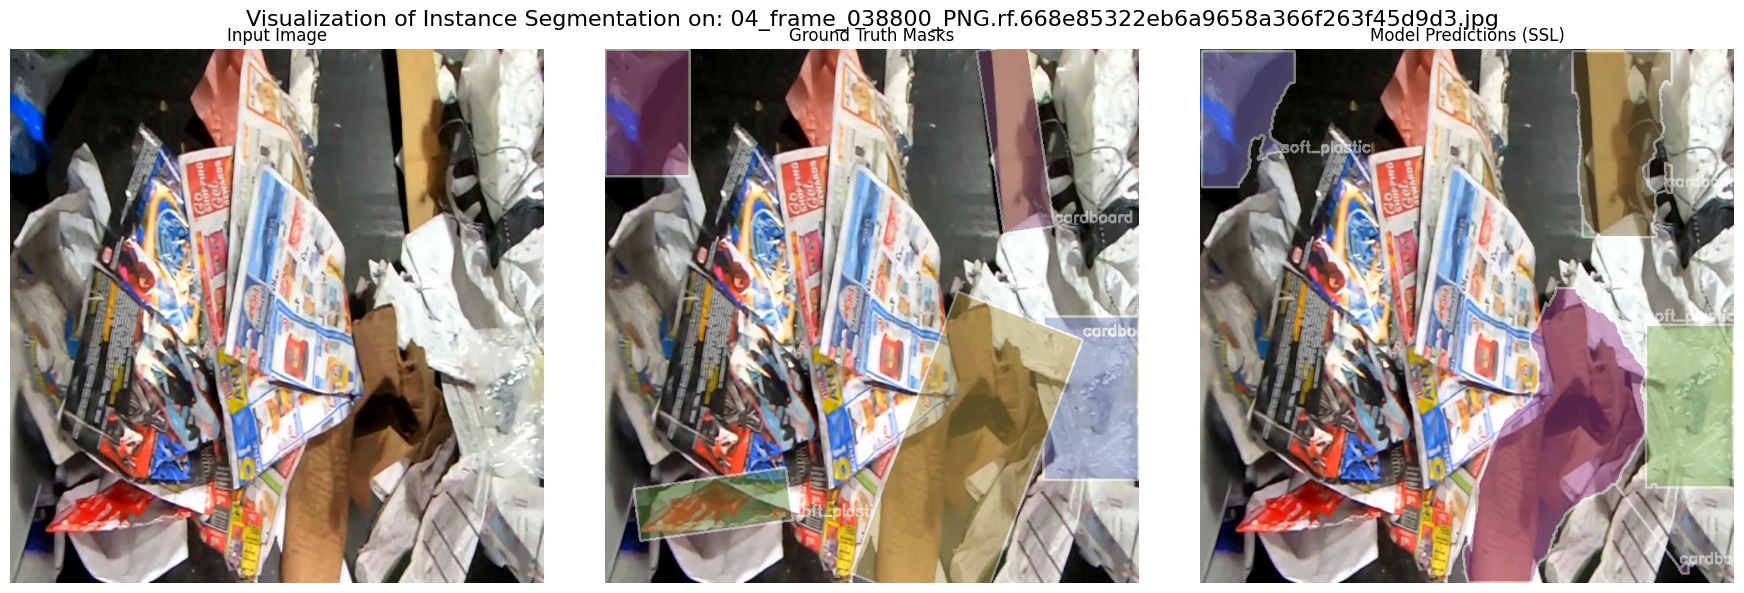

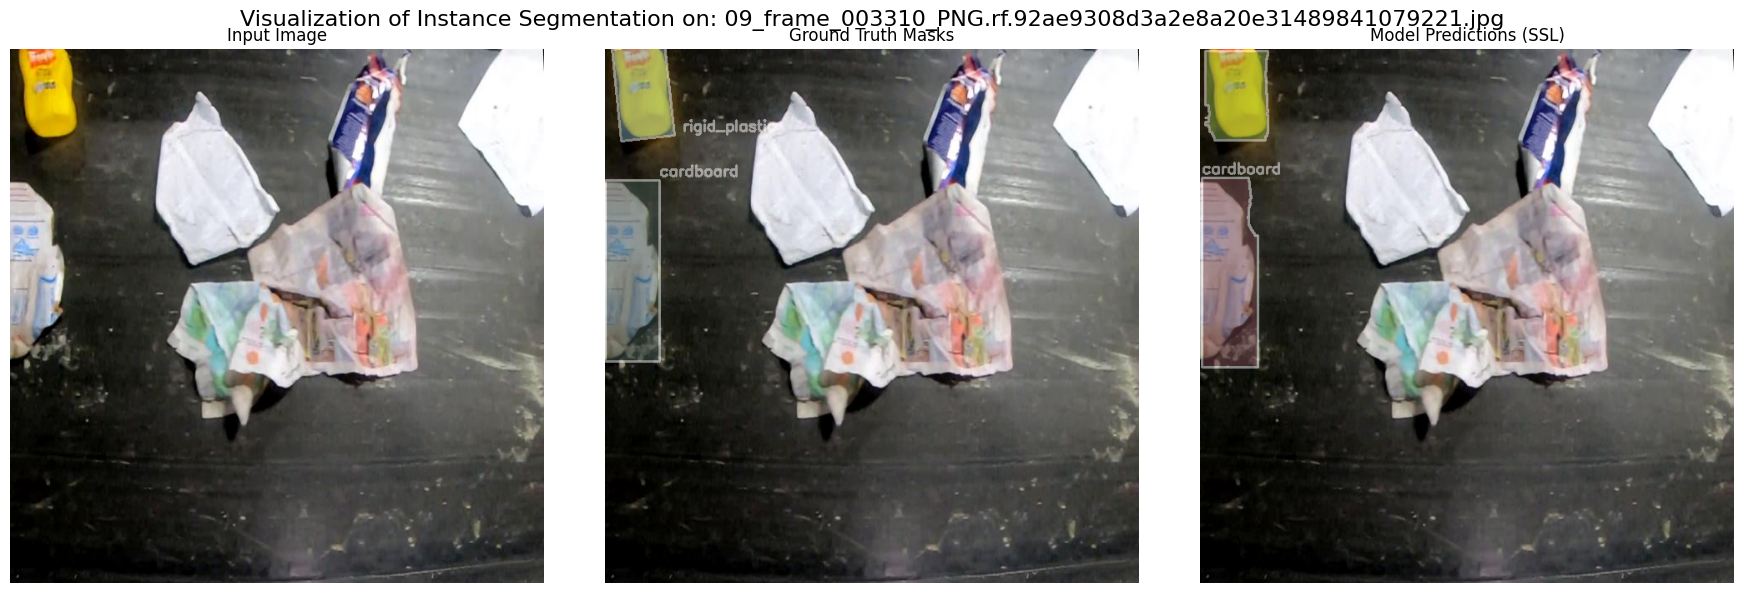

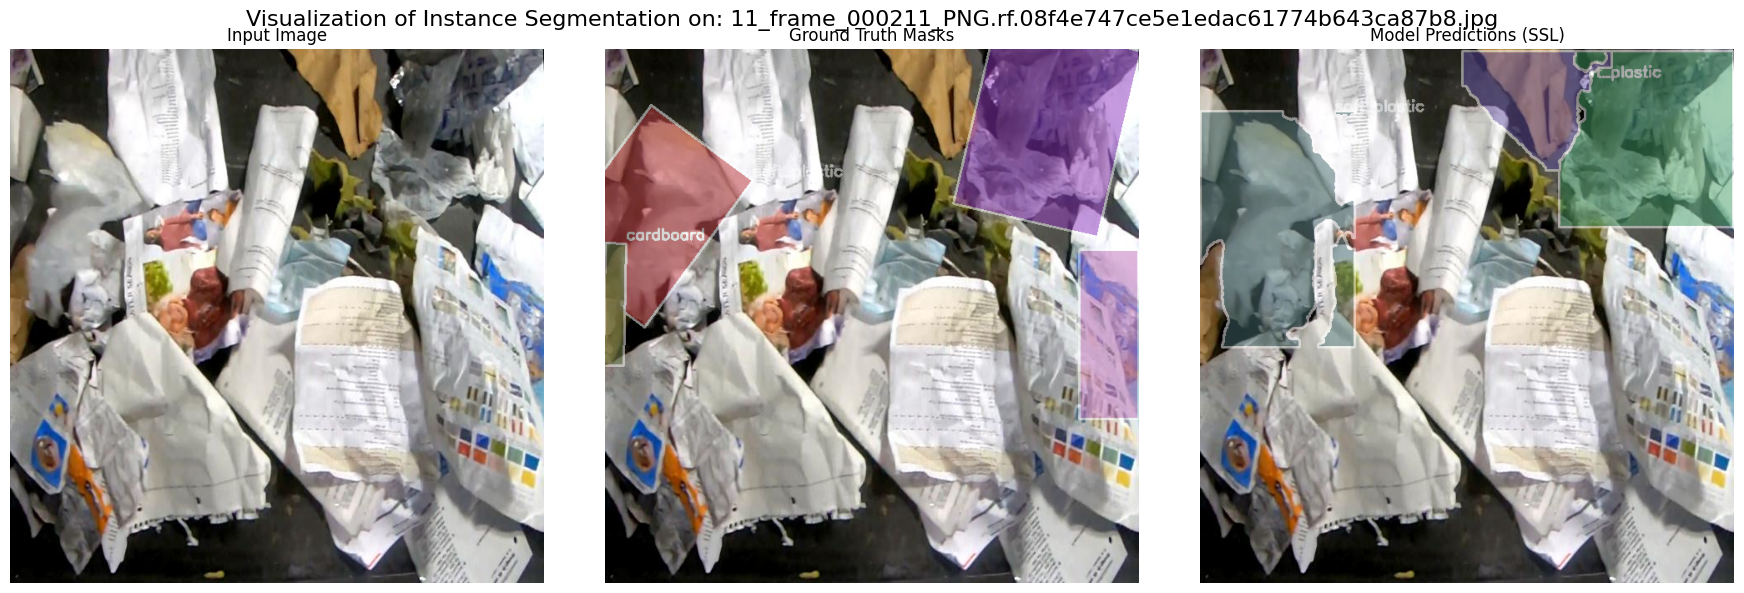

In [16]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from ultralytics import YOLO
import glob

# ============================================================
# Visualization
# ============================================================

# --- Find the latest training run ---
runs_dir = "/kaggle/working/runs/segment"
all_run_dirs = glob.glob(os.path.join(runs_dir, "mixmatch_epoch_*"))
all_run_dirs.sort(key=os.path.getctime, reverse=True)

if all_run_dirs:
    latest_run_dir = all_run_dirs[0]
    MODEL_PATH = os.path.join(latest_run_dir, "weights", "best.pt")
    print(f"Using trained model from: {MODEL_PATH}")
else:
    # Fallback or error handling if no run is found
    print("No trained model found in runs/segment. Using the base model for demonstration.")
    
    MODEL_PATH = "yolo12n.pt" 

# Load the trained model
try:
    final_model = YOLO(MODEL_PATH)
except Exception as e:
    print(f"Error loading model: {e}")
    final_model = YOLO("yolo12n.pt")

# Get the class names from the YAML configuration
import yaml
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)
CLASS_NAMES = data_config.get('names', [])

def get_yolo_masks_from_txt(label_path, h, w, class_names):
    """Parses YOLO segmentation format (.txt) to return a list of polygons/masks and class names."""
    masks_data = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                values = list(map(float, line.strip().split()))
                cls_id = int(values[0])
                coords = values[1:]
                
                if len(coords) >= 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    
                    class_name = class_names[cls_id] if cls_id < len(class_names) else f"Class {cls_id}"
                    masks_data.append((class_name, pts))
    return masks_data

def visualize_results(img_path, class_names, model):
    """Visualizes Input, Ground Truth, and Model Predictions."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # --- 1. Ground Truth (GT) Mask ---
    label_path = img_path.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    gt_masks_data = get_yolo_masks_from_txt(label_path, h, w, class_names)
    gt_overlay = img.copy()
    for class_name, pts in gt_masks_data:
        color = tuple(np.random.randint(50, 200, 3).tolist())
        cv2.fillPoly(gt_overlay, [pts], color)
        cv2.polylines(gt_overlay, [pts], True, (255, 255, 255), 2)
        cv2.putText(gt_overlay, class_name, (pts[0][0], pts[0][1] - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    gt_vis = cv2.addWeighted(cv2.cvtColor(gt_overlay, cv2.COLOR_BGR2RGB), 0.5, img_rgb, 0.5, 0)
    
    # --- 2. Model Prediction (Pred) Mask ---
    pred_overlay = img.copy()
    # Ensure prediction is run on the correct image format (cv2 reads as BGR)
    results = model.predict(source=img, imgsz=640, conf=0.25, verbose=False) 
    
    if results and results[0].masks is not None:
        for seg_data, cls_id in zip(results[0].masks.xy, results[0].boxes.cls.tolist()):
            pts = np.array(seg_data).astype(np.int32)
            class_name = class_names[int(cls_id)] if int(cls_id) < len(class_names) else f"Class {int(cls_id)}"
            
            color = tuple(np.random.randint(50, 200, 3).tolist())
            cv2.fillPoly(pred_overlay, [pts], color)
            cv2.polylines(pred_overlay, [pts], True, (255, 255, 255), 2)
            cv2.putText(pred_overlay, class_name, (pts[0][0], pts[0][1] - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    pred_vis = cv2.addWeighted(cv2.cvtColor(pred_overlay, cv2.COLOR_BGR2RGB), 0.5, img_rgb, 0.5, 0)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    axes[1].imshow(gt_vis)
    axes[1].set_title("Ground Truth Masks")
    axes[1].axis("off")

    axes[2].imshow(pred_vis)
    axes[2].set_title("Model Predictions (SSL)")
    axes[2].axis("off")

    plt.suptitle(f"Visualization of Instance Segmentation on: {os.path.basename(img_path)}", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Run Visualization on a few test images ---
# Get 3-4 images from the validation set for visualization
VAL_IMAGE_DIR = data_config.get('val', "").replace("/images", "") 
if VAL_IMAGE_DIR:
    
    val_img_files = glob.glob(os.path.join(VAL_IMAGE_DIR, "images", "*.jpg")) + \
                    glob.glob(os.path.join(VAL_IMAGE_DIR, "images", "*.png"))
    
    if val_img_files:
        sample_vis_files = random.sample(val_img_files, min(len(val_img_files), 3))
        
        for img_file in sample_vis_files:
            visualize_results(img_file, CLASS_NAMES, final_model)
    else:
        print(f"Could not find images in {VAL_IMAGE_DIR}/images for visualization.")
else:
    print("Validation path not found in data.yaml for visualization.")

# Evaluation

In [18]:
# ============================================================
# Final Evaluation (mAP)
# ============================================================

from ultralytics import YOLO

print("\n" + "="*50)
print(" Final Evaluation of MixMatch Model (Mask mAP Metrics) ")
print("="*50)



# Load the final trained model
try:
    final_model = YOLO(MODEL_PATH)
except Exception as e:
    print(f"Error loading model for final evaluation: {e}")
    

if 'final_model' in locals():
    # Run validation on the validation set specified in data.yaml
    metrics = final_model.val(data=DATA_YAML,
                              imgsz=640,
                              batch=8,
                              device=0 if torch.cuda.is_available() else 'cpu',
                              split='val')

    # Extract and display the key instance segmentation metrics
    print("\n" + "*"*30)
    print("Instance Segmentation Metrics (Mask mAP)")
    print("*"*30)
    
    # Mask mAP@0.5
    mask_map50 = metrics.seg.map50
    print(f"• Mask mAP@0.5: {mask_map50:.4f}")

    # Mask mAP@0.5:0.95 (Average mAP over multiple IoU thresholds)
    mask_map = metrics.seg.map
    print(f"• Mask mAP@0.5:0.95: {mask_map:.4f}")
    
    # IoU-based metrics (YOLO's mAP is inherently IoU-based, this is the standard output)
    print("\n--- IoU-based metrics (from YOLO val output) ---")
    print(f"• Box mAP@0.5: {metrics.box.map50:.4f}")
    print(f"• Box mAP@0.5:0.95: {metrics.box.map:.4f}")
    
    
    print("\nEvaluation complete.")
else:
    print("Evaluation skipped due to error loading the trained model.")


 Final Evaluation of MixMatch Model (Mask mAP Metrics) 
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO12n-seg summary (fused): 172 layers, 2,810,509 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1155.9±211.3 MB/s, size: 55.8 KB)
val: Scanning /kaggle/working/dataset/valid/labels.cache... 1290 images, 9 backgrounds, 20 corrupt: 100% ━━━━━━━━━━━━ 1290/1290 1.8Mit/s 0.0s0s
val: /kaggle/working/dataset/valid/images/01_frame_040300_PNG.rf.c5140dc39296ee80931c1cc0c3cee9ee.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0881]
val: /kaggle/working/dataset/valid/images/08_frame_012100_PNG.rf.f4b2be3bc7ee1a3c5cd806a515abbd02.jpg: 3 duplicate labels removed
val: /kaggle/working/dataset/valid/images/AluCan29_jpg.rf.931d106191ef0eeb3f63ce3556281b8b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.052]
val: /kaggle/working/dataset/valid/image

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.667      0.631      0.678      0.465      0.647       0.62      0.649      0.391
             Aluminium        151        154      0.791      0.623      0.767      0.597      0.793      0.623      0.769      0.568
                 Glass        104        116      0.689      0.862      0.851      0.652      0.642      0.802       0.79      0.422
                   Tag        267        301      0.694      0.711      0.709      0.449      0.698      0.714      0.696      0.412
            cardboard         566       2312      0.656      0.406      0.495      0.281      0.614      0.378      0.434      0.181
         rigid_plastic        609        682      0.857      0.661      0.748      0.563      0.844       0.65      0.721      0.413
          soft_plastic        429        895      0.599      0.243      0.351      0.171      0.532      0.214      0.296      0.113
                  wood         23         23      0.385      0.913   